<a href="https://www.kaggle.com/code/testanother/votingclassifier-cnn-tuning-for-99-accuracy?scriptVersionId=116358150" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix

import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from tensorflow.keras.optimizers import Adam

from keras_tuner import RandomSearch

## Agenda

In this notebook I will show how one can do multiclass classification using MNIST and hopefully provide some helper methods and references for you to use

Will do the following: 

- EDA
- VotingClassifier with K-Means and RandomForest with hyperparameter tuning
- CNN
- CNN with Keras tuning

I will load and visualize data and try certain models to compare performances of them. 


In [3]:
df_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
df_submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

X = df_train.drop(["label"], axis=1)
y = df_train["label"]

In [4]:
# Divide train data to test and train for measuring accuraccy and other metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [6]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Label indicates the number row corresponds to. We can verify by visualizing this.

9


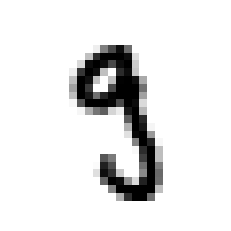

In [7]:
def draw_digit(digit_data):
    # 28 because we have 784 columns and square root is 28
    img = digit_data.reshape(28, 28)
    plt.imshow(img, cmap=mpl.cm.binary)
    plt.axis("off")
    plt.show()

print(y_train.iloc[3])
draw_digit(np.array(X_train.iloc[3]))

## Multiclass Classification


In [8]:
params = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5]}]

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, params, verbose=4)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.966 total time=   5.6s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.963 total time=   5.1s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.963 total time=   5.6s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.961 total time=   5.3s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.961 total time=   5.6s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.968 total time=   5.8s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.965 total time=   5.3s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.965 total time=   5.1s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.964 total time=   5.3s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.962 total time=   5.2s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.963 total time=   6.2s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=4)

In [9]:
print(grid_search.best_params_, grid_search.best_score_)

{'n_neighbors': 4, 'weights': 'distance'} 0.9654421768707483


In [10]:
y_test_grid = grid_search.predict(X_test)
accuracy_score(y_test, y_test_grid)

0.9661904761904762

In [11]:
rnd_clf = RandomForestClassifier()

rf_param_grid = {"n_estimators": [100, 300]}

gsRFC = GridSearchCV(rnd_clf, param_grid = rf_param_grid, cv=3, scoring="accuracy", verbose=4)

gsRFC.fit(X_train,y_train)

print(gsRFC.best_params_, gsRFC.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END ..................n_estimators=100;, score=0.960 total time=  10.9s
[CV 2/3] END ..................n_estimators=100;, score=0.958 total time=  10.9s
[CV 3/3] END ..................n_estimators=100;, score=0.955 total time=  11.5s
[CV 1/3] END ..................n_estimators=300;, score=0.960 total time=  32.9s
[CV 2/3] END ..................n_estimators=300;, score=0.962 total time=  32.8s
[CV 3/3] END ..................n_estimators=300;, score=0.954 total time=  33.1s
{'n_estimators': 300} 0.9588435374149659


In [12]:
knn_best = KNeighborsClassifier(n_neighbors=4, weights='distance')
rnd_best = RandomForestClassifier(n_estimators=300)

votingC = VotingClassifier(estimators=[('rfc', rnd_best), ('knnc', knn_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [13]:
preds = votingC.predict(df_test)
preds

array([2, 0, 9, ..., 3, 9, 2])

In [14]:
preds_new = pd.Series(preds, name="Label")
preds_new

0        2
1        0
2        9
3        9
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

In [15]:
submission_voting = pd.concat([pd.Series(range(1,28001), name="ImageId"), preds_new],axis = 1)
submission_voting

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [16]:
#submission_voting.to_csv("voting_submission.csv",index=False) -> 96% score

## Using Convolutional Neural Networks

Now we can try with CNN's. Before we do that though we have to rescale the data

In [17]:
X_scaled = X / 255.0
df_test = df_test / 255.0

In [18]:
X_scaled = X_scaled.values.reshape(-1, 28, 28, 1)
df_test = df_test.values.reshape(-1, 28, 28, 1)

We also need to convert the labels so they look like [0,0,1,0,0,0,0,0,0] instead of 2

In [19]:
y_converted = to_categorical(y, num_classes = 10)

In [20]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_converted, test_size = 0.3)

In [21]:
# In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

2023-01-14 17:35:21.779200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:35:21.878213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:35:21.878988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 17:35:21.881575: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [23]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [24]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=5,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

datagen.fit(X_train_scaled)

In [25]:
history = model.fit_generator(datagen.flow(X_train_scaled,y_train_scaled, batch_size=250),
                              epochs = 10, validation_data = (X_test_scaled,y_test_scaled), steps_per_epoch=X_train.shape[0] // 250)
print(history.history.keys(), history.params)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2023-01-14 17:35:24.871059: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-14 17:35:26.207326: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


117/117 [==============================] - 15s 65ms/step - loss: 1.2128 - accuracy: 0.5963 - val_loss: 0.2537 - val_accuracy: 0.9331
Epoch 2/10
117/117 [==============================] - 7s 60ms/step - loss: 0.4918 - accuracy: 0.8425 - val_loss: 0.1503 - val_accuracy: 0.9545
Epoch 3/10
117/117 [==============================] - 7s 61ms/step - loss: 0.3600 - accuracy: 0.8858 - val_loss: 0.1158 - val_accuracy: 0.9655
Epoch 4/10
117/117 [==============================] - 7s 57ms/step - loss: 0.3087 - accuracy: 0.9040 - val_loss: 0.1005 - val_accuracy: 0.9702
Epoch 5/10
117/117 [==============================] - 7s 60ms/step - loss: 0.2650 - accuracy: 0.9173 - val_loss: 0.0874 - val_accuracy: 0.9729
Epoch 6/10
117/117 [==============================] - 7s 61ms/step - loss: 0.2364 - accuracy: 0.9280 - val_loss: 0.0824 - val_accuracy: 0.9734
Epoch 7/10
117/117 [==============================] - 8s 65ms/step - loss: 0.2210 - accuracy: 0.9341 - val_loss: 0.0738 - val_accuracy: 0.9770
Epoch 8/1

Now it is time to evaluate the model

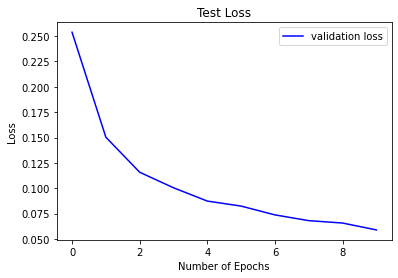

In [26]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The graph above plots the loss and accuracy curve for training and test

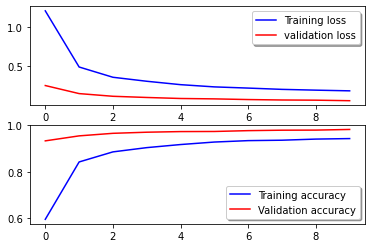

In [27]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

We get 99% accuracy on 2 epochs which is really good. Validation accuracy is larger than training accuracy which also means that we are not overfitting.

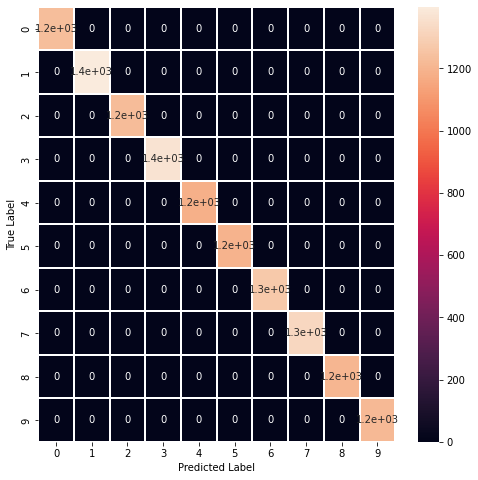

In [28]:
Y_pred = model.predict(X_test_scaled)
Y_pred_classes = np.argmax(y_test_scaled,axis = 1) 
Y_true = np.argmax(y_test_scaled,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

How do you make sense of this ? Take number 1 for true label and predicted label. If the value is > 0 for a cell it means there is a relationship between them. All other values are 0 for 1 except for 1 in true and predicted. Which means there is a correlation between true label 1 and predicted 1 which is the true prediction

Lets plot for Knn

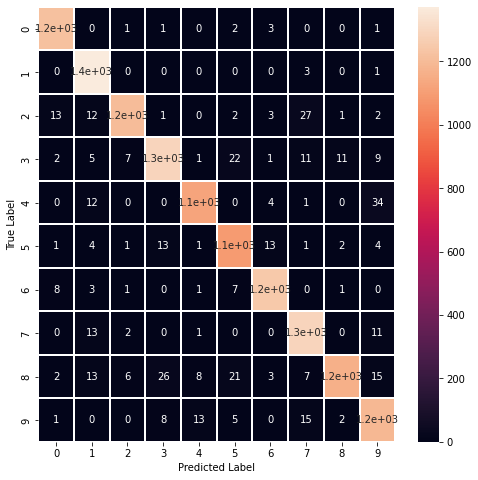

In [29]:
confusion_mtx = confusion_matrix(y_test, y_test_grid) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [30]:
preds = model.predict(df_test)
preds = np.argmax(preds, axis = 1)
preds = pd.Series(preds, name="Label")

In [31]:
# uncomment to submit. This will give 98% score
#submission = pd.concat([pd.Series(range(1,28001), name="ImageId"), preds],axis = 1)
#submission.to_csv("cnn_submission.csv",index=False)

We can do a random search on the created CNN model as well and see if we can do any better than 98% score

In [32]:
def create_model(hp):
    model = Sequential()
    model.add(Conv2D(filters = hp.Int('conv_1_filter', min_value=2, max_value=32, step=2), 
                     kernel_size = hp.Choice('conv_1_kernel', values = [3,5,7]),
                     padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters = hp.Int('conv_1_filter', min_value=2, max_value=32, step=2), 
                     kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                     padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_1_units', min_value=128, max_value=256, step=32), 
                    activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[0.001, 0.01, 0.1]),
                                hp.Choice('beta_1', values=[0.9, 1.0, 0.1]),
                                hp.Choice('beta_2', values=[0.999, 1.0, 0.1])), 
                  loss = "categorical_crossentropy", metrics=["accuracy"])
    return model

tuner = RandomSearch(create_model, objective='val_accuracy', max_trials = 3)
tuner.search(X_train_scaled,y_train_scaled,epochs=10,validation_data=(X_test_scaled,y_test_scaled))

Trial 3 Complete [00h 00m 40s]
val_accuracy: 0.9873015880584717

Best val_accuracy So Far: 0.9906349182128906
Total elapsed time: 00h 02m 01s


In [33]:
tuned_model = tuner.get_best_models(num_models=1)[0]
#summary of best model
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 30)        1500      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 30)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 30)        22530     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1470)              0

In [34]:
history = tuned_model.fit_generator(datagen.flow(X_train_scaled,y_train_scaled, batch_size=250),
                              epochs = 10, validation_data = (X_test_scaled,y_test_scaled), steps_per_epoch=X_train.shape[0] // 250)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
117/117 [==============================] - 7s 60ms/step - loss: 0.1809 - accuracy: 0.9452 - val_loss: 0.0283 - val_accuracy: 0.9909
Epoch 2/10
117/117 [==============================] - 7s 60ms/step - loss: 0.1103 - accuracy: 0.9675 - val_loss: 0.0283 - val_accuracy: 0.9913
Epoch 3/10
117/117 [==============================] - 7s 61ms/step - loss: 0.0900 - accuracy: 0.9726 - val_loss: 0.0264 - val_accuracy: 0.9913
Epoch 4/10
117/117 [==============================] - 8s 67ms/step - loss: 0.0843 - accuracy: 0.9748 - val_loss: 0.0271 - val_accuracy: 0.9920
Epoch 5/10
117/117 [==============================] - 7s 59ms/step - loss: 0.0784 - accuracy: 0.9757 - val_loss: 0.0258 - val_accuracy: 0.9921
Epoch 6/10
117/117 [==============================] - 7s 63ms/step - loss: 0.0692 - accuracy: 0.9788 - val_loss: 0.0256 - val_accuracy: 0.9920
Epoch 7/10
117/117 [==============================] - 8s 66ms/step - loss: 0.0691 - accuracy: 0.9789 - val_loss: 0.0242 - val_accuracy: 0.9925

In [35]:
new_preds = tuned_model.predict(df_test)
new_preds = np.argmax(new_preds, axis = 1)
new_preds = pd.Series(new_preds, name="Label")

In [36]:
submission_tuned = pd.concat([pd.Series(range(1,28001), name="ImageId"), new_preds],axis = 1)
# Uncomment to submit, This will give 99228% accuracy score
#submission_tuned.to_csv("tuned_submission.csv",index=False)